## Failure ratio of master jobs
Jobs initiated in a period of 1 week over the last 12 weeks

In [1]:
%matplotlib inline
import sys
import os
import datetime, calendar
import azure.cosmos.cosmos_client as cosmos_client
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
client = cosmos_client.CosmosClient(url_connection=os.environ['endpoint'], auth={'masterKey': os.environ['masterKey']})

database_link = 'dbs/' + os.environ['databaseId']
collection_link = database_link + '/colls/{}'.format(os.environ['containerId'])

In [3]:
last_sunday = datetime.date.today()
one_day = datetime.timedelta(days=1)
one_week = datetime.timedelta(days=7)

while last_sunday.weekday() != calendar.SUNDAY:
    last_sunday -= one_day
    
# Number of weeks we want to go back in
weeks_in_past = 13
    
reversed_sundays = list(
    map(
        lambda week: (last_sunday - (week * one_week)).isoformat(),
        range(weeks_in_past)
    )
)

sundays = reversed_sundays[::-1]

sundays

first_sunday, *tail_sundays = sundays

query = {
    "query": """
     SELECT c.job_name, c.build_id, c.current_build_current_result, c.stage_timestamp, c._ts
     FROM c
     WHERE c.current_build_scheduled_time > '{0}Z'
         and c.branch_name = 'master'
    """.format(first_sunday)
}

query_results = list(client.QueryItems(collection_link, query))

df = pd.DataFrame(query_results)

In [4]:
def week_builds(week_df):
    return pd.DataFrame(
        week_df
            .sort_values(by='stage_timestamp')
            .drop_duplicates('job_name', keep='last')
    )

def week_df(frame, week_number):
    return frame[
        (frame['stage_timestamp'] > sundays[week_number])
        & (frame['stage_timestamp'] < sundays[week_number + 1])
    ]

builds = list(
    map(
        lambda week_number: week_builds(week_df(df, week_number)),
        range(weeks_in_past - 1)
    )
)

In [5]:
def week_stats(current_build):
    total_rows = len(current_build)
    successes = len(current_build.loc[df['current_build_current_result'] == 'SUCCESS'])
    failures = len(current_build.loc[df['current_build_current_result'] == 'FAILURE'])
    aborted = len(current_build.loc[df['current_build_current_result'] == 'ABORTED'])
    unknows = total_rows - successes - failures - aborted
    success_ratio = round(successes/(successes + failures + aborted) * 100)
    return ({
        "success ratio": success_ratio,
        "stats": [successes, failures, aborted, unknows],
        "stats_labels": ['SUCCESS', 'FAILURE', 'ABORTED', 'UNKNOWN'],
    })



week_stats(builds[0])

all_weeks_stats = list(
    map(
        lambda week_builds: week_stats(week_builds),
        builds
    )
)

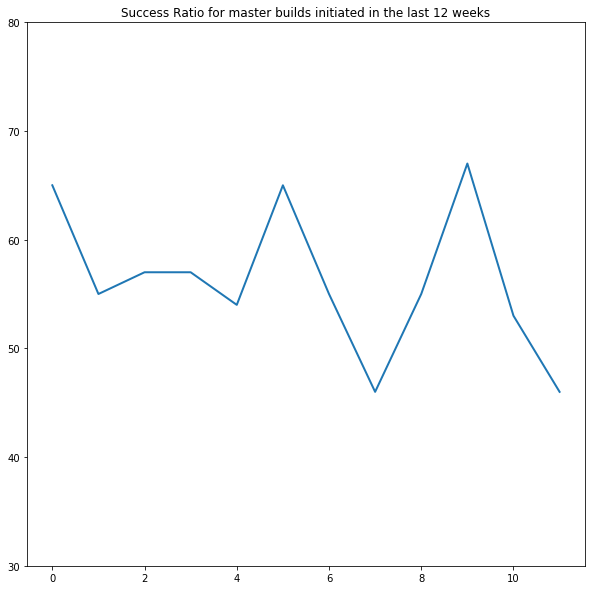

In [6]:
success_ratios = list(
    map(
        lambda all_weeks_stats: all_weeks_stats['success ratio'],
        all_weeks_stats
    )
)

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_title('Success Ratio for master builds initiated in the last {0} weeks'.format(weeks_in_past - 1))
plt.plot(list(range(weeks_in_past - 1)), success_ratios, linewidth=2)
plt.ylim(top=100, bottom=0)
plt.show()